### Import all packages we may use

In [202]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Make a list of calibration images

In [203]:
images = glob.glob('camera_cal/calibration*.jpg')

### Camera Calibration

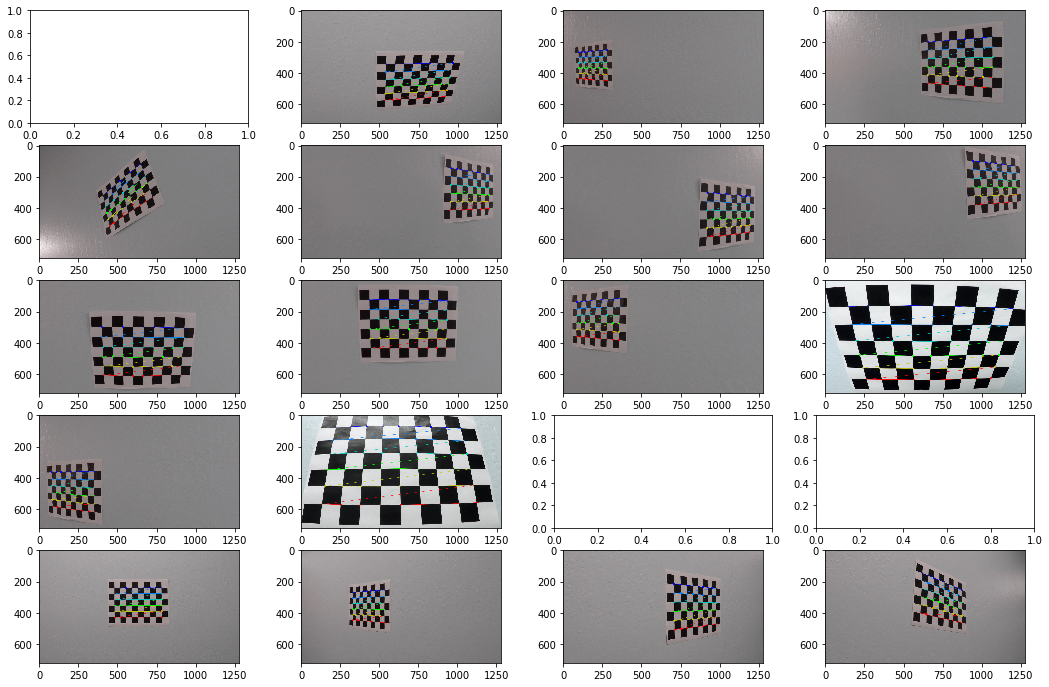

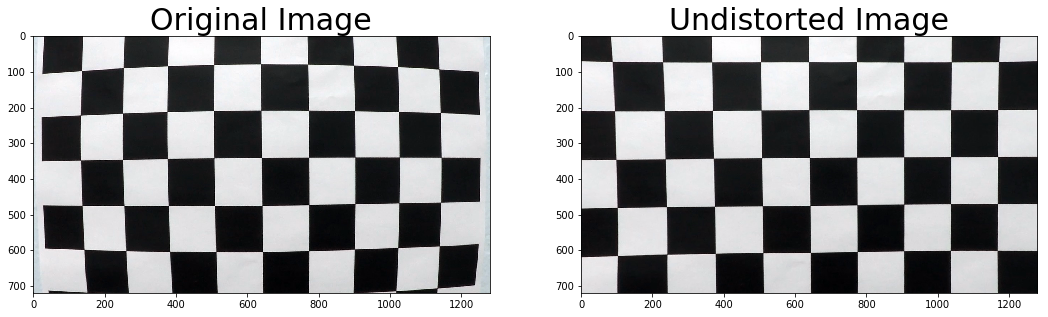

In [204]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

nx, ny = 9, 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[:9,:6].T.reshape(-1,2)

f, axs = plt.subplots(5, 4, figsize = (18, 12))
axs = axs.ravel()
output_dir = 'output_images/'

for i, fname in enumerate(images):
    # Read images
    img = cv2.imread(fname)
    
    # Convert it to grayscale for finding corners
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    # If found, add object points and image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw, display corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        axs[i].imshow(img)
        
        # Save it
        save_dir = output_dir + 'corners/' + 'corners' + fname.split('/')[1]
        cv2.imwrite(save_dir, img)

# Test undistortion on a chessboard image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Compute calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Define a undistortion function for further use(test and pipeline)
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Undistort
dst = undistort(img)

# Display
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 12))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize = 30)

# Save these two images for writeup template
cv2.imwrite(output_dir + 'undistortion_chessboard_example/' + 'distorted_calibration1.jpg', img)
cv2.imwrite(output_dir + 'undistortion_chessboard_example/' + 'undistorted_calibration1.jpg', img)

# Save the camera calibration results
dst_pickle = {}
dst_pickle['mtx'] = mtx
dst_pickle['dist'] = dist
pickle.dump(dst_pickle, open('camera_dist_pickle.p', 'wb'))



### Test the undistortion in a test image

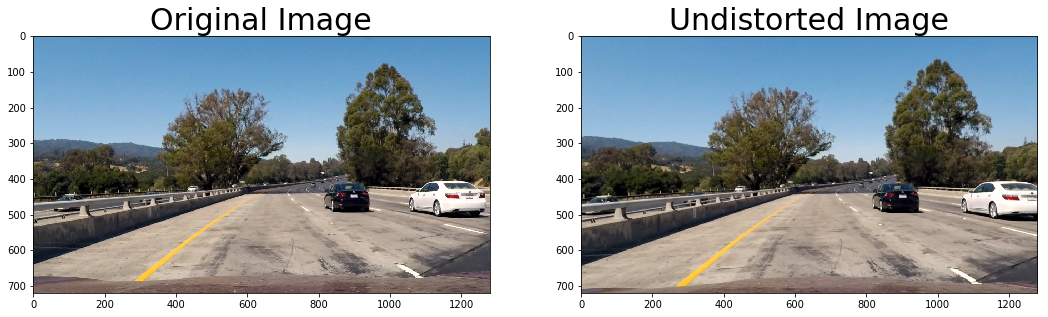

In [205]:
# Test undistortion on a test image
img = cv2.imread('test_images/test1.jpg')
dst = undistort(img)

# Save for writeup template
cv2.imwrite(output_dir + 'undistortion_test_images/' + 'distorted_test1.jpg', img)
cv2.imwrite(output_dir + 'undistortion_test_images/' + 'undistorted_test1.jpg', dst)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 12))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize = 30)

### Using Color Transform and Gradient to create a binary image

In [206]:
# Sobel methods

# X direction sobel
def sobelx(img, sobelx_thresh = (0,255), k_size = 3):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take derivative on x
    sbx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=k_size)
    abs_sbx = np.abs(sbx)
    scaled_sbx = np.uint8(255*abs_sbx/np.max(abs_sbx))
    binary_sbx = np.zeros_like(scaled_sbx)
    binary_sbx[(scaled_sbx >= sobelx_thresh[0]) & (scaled_sbx <= sobelx_thresh[1])] = 1
    return binary_sbx

# Magnitude
def mag_sobel(img, mag_thresh = (0,255), k_size = 3):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sbx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = k_size)
    sby = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = k_size)
    mag_sb = np.sqrt(sbx**2 + sby**2)
    scaled_sb = np.uint8(255*mag_sb/np.max(mag_sb))
    binary_mag = np.zeros_like(scaled_sb)
    binary_mag[(scaled_sb >= mag_thresh[0]) & (scaled_sb <= mag_thresh[1])] = 1
    return binary_mag

# Directional Sobel
def dir_sobel(img, dir_thresh = (0, np.pi/2), k_size = 3):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sbx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = k_size)
    sby = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = k_size)
    abs_sbx = np.abs(sbx)
    abs_sby = np.abs(sby)
    grad_dir = np.arctan2(abs_sby, abs_sbx)
    binary_dir = np.zeros_like(grad_dir)
    binary_dir[(grad_dir >= dir_thresh[0]) & (grad_dir <= dir_thresh[1])] = 1
    return binary_dir

# S_channel
def schannel(img, s_thresh = (0,255)):
    s_channel = img[:,:,2]
    binary_s = np.zeros_like(s_channel)
    binary_s[(s_channel>=s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return binary_s

# H_channel
def hchannel(img, h_thresh = (0,255)):
    h_channel = img[:,:,0]
    binary_h = np.zeros_like(h_channel)
    binary_h[(h_channel>=h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    return binary_h

# L channel
def lchannel(img, l_thresh = (0,255)):
    l_channel = img[:,:,1]
    binary_l = np.zeros_like(l_channel)
    binary_l[(l_channel>=l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    return binary_l

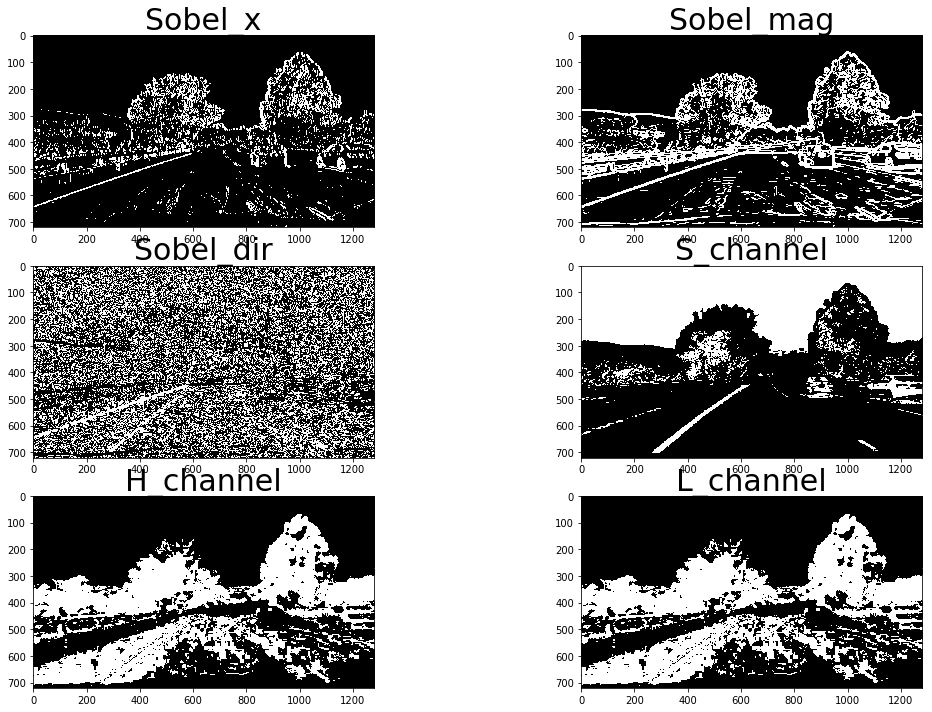

In [207]:
f, axs = plt.subplots(3,2, figsize = (18, 12))
axs = axs.ravel()

img = dst

binary_sbx = sobelx(img, sobelx_thresh = (20,255), k_size = 15)
binary_mag = mag_sobel(img, mag_thresh = (25,255), k_size = 25)
binary_dir = dir_sobel(img, dir_thresh = (0.7, 1.3), k_size = 25)

hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)

binary_s = schannel(hls_img, s_thresh = (90,255))
binary_h = hchannel(hls_img, h_thresh = (15,100))
binary_l = lchannel(hls_img, l_thresh = (40,255))

axs[0].imshow(binary_sbx, cmap = 'gray')
axs[0].set_title('Sobel_x', fontsize = 30)
axs[1].imshow(binary_mag, cmap = 'gray')
axs[1].set_title('Sobel_mag', fontsize = 30)
axs[2].imshow(binary_dir, cmap = 'gray')
axs[2].set_title('Sobel_dir', fontsize = 30)

axs[3].imshow(binary_s, cmap = 'gray')
axs[3].set_title('S_channel', fontsize = 30)
axs[4].imshow(binary_h, cmap = 'gray')
axs[4].set_title('H_channel', fontsize = 30)
axs[5].imshow(binary_h, cmap = 'gray')
axs[5].set_title('L_channel', fontsize = 30)                    

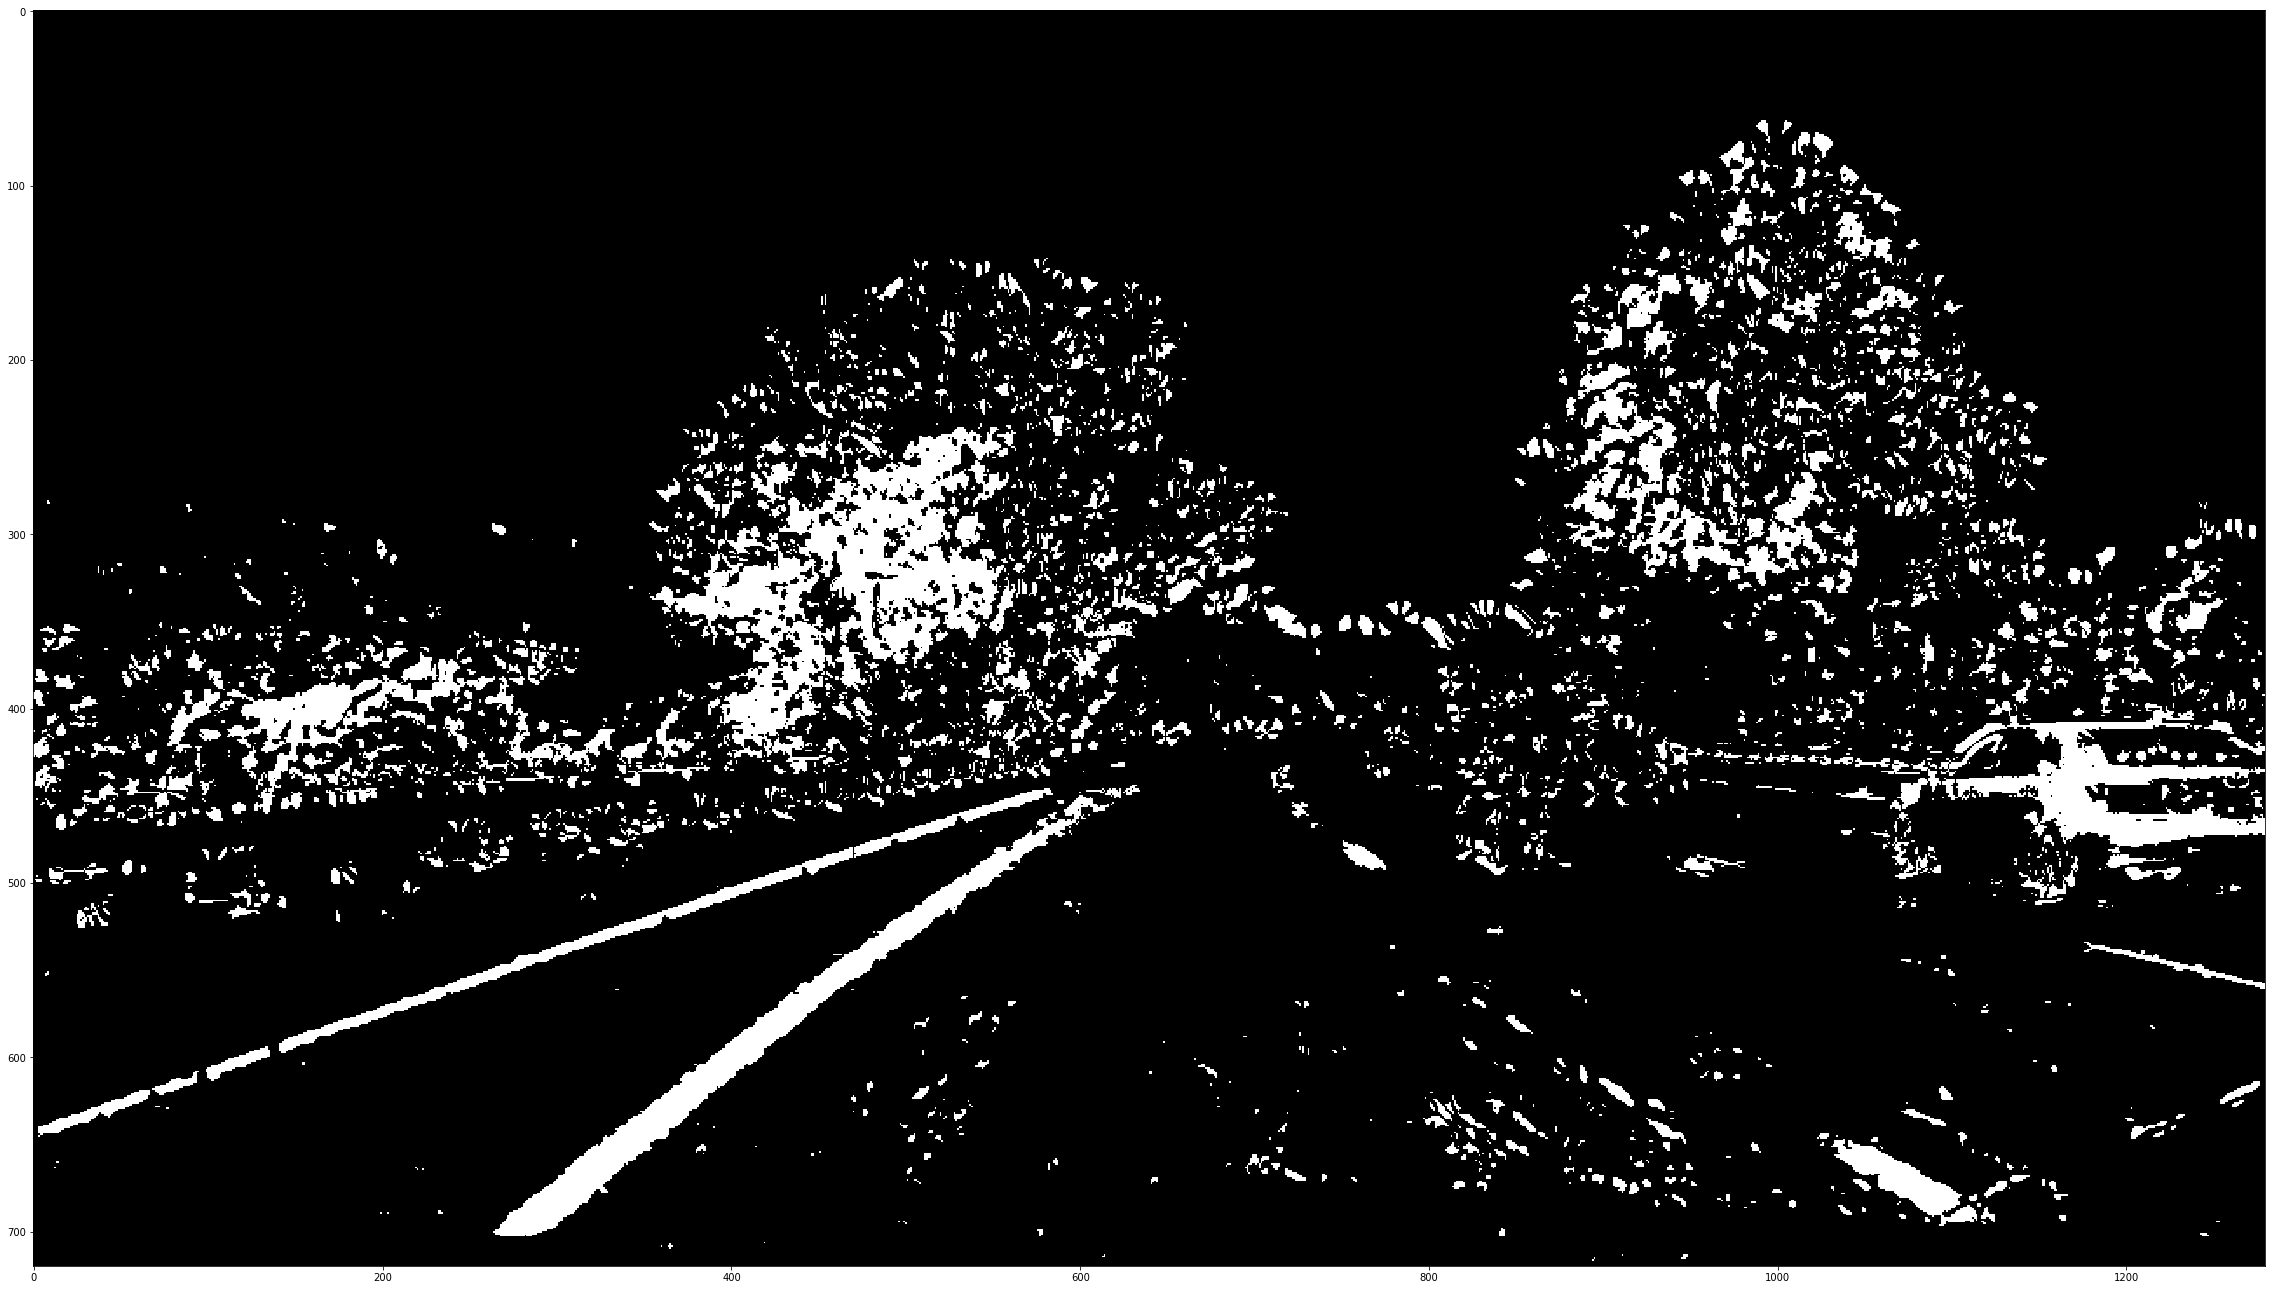

In [209]:
# I think combine sobel_x, sobel_dir, s_channel and h_channel will gives me good lane detection
def binary_image(img):
    binary_sbx = sobelx(img, sobelx_thresh = (20,255), k_size = 15)
    #binary_mag = mag_sobel(img, mag_thresh = (25,255), k_size = 25)
    binary_dir = dir_sobel(img, dir_thresh = (0.7, 1.3), k_size = 25)
    
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    binary_s = schannel(hls_img, s_thresh = (90,255))
    binary_h = hchannel(hls_img, h_thresh = (15,100))
    #binary_l = lchannel(hls_img, l_thresh = (40,255))
    
    binary_output = np.zeros_like(binary_sbx)
    binary_output [(((binary_sbx == 1) & (binary_dir == 1)) | ((binary_s ==1) & (binary_h ==1)))] = 1
    return binary_output

f, ax = plt.subplots(figsize = (40, 30))
ax.imshow(binary_image(img), cmap = 'gray')

### Perspective Transform

In [210]:
image_size = (img.shape[1], img.shape[0])
src = np.float32([(578,460),
                  (190,720),
                  (1130,720),
                  (705,460) 
                  ])

dst = np.float32([(230,0),
                  (230,image_size[1]),
                  (image_size[0]-230,image_size[1]),
                  (image_size[0]-230,0)
                  ])

def warp(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    return warped, M, Minv

    

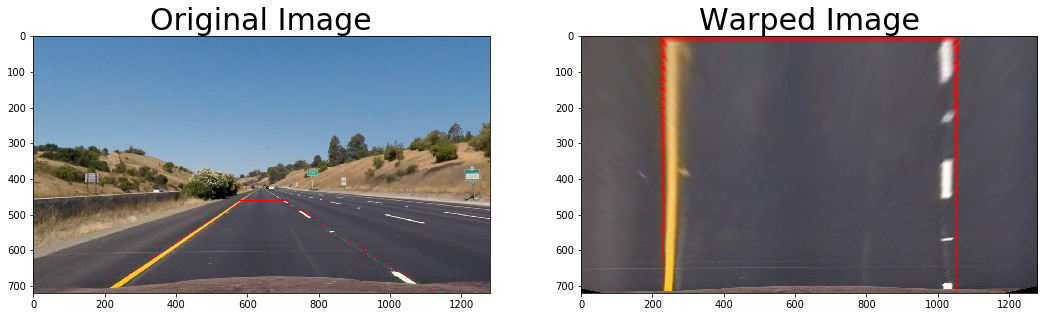

In [211]:
# Test perspective transform on straight image
img = cv2.imread('test_images/straight_lines1.jpg')
img = undistort(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cv2.line(img, tuple(src[0]), tuple(src[1]), color=[255,0,0], thickness=1)
cv2.line(img, tuple(src[1]), tuple(src[2]), color=[255,0,0], thickness=1)
cv2.line(img, tuple(src[2]), tuple(src[3]), color=[255,0,0], thickness=1)
cv2.line(img, tuple(src[3]), tuple(src[0]), color=[255,0,0], thickness=1)

f, (ax1, ax2) = plt.subplots(1,2, figsize = (18, 12))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 30)

warped_img, M, Minv = warp(img, src, dst)
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize = 30)

# Save, since this it RGB channels, using plt.imsave
plt.imsave(output_dir + 'warped_images/' + 'straight_line1.jpg', img)
plt.imsave(output_dir + 'warped_images/' + 'warped_straight_line1.jpg', warped_img)

### Pipeline

In [212]:
def pipeline(img):
    undst = undistort(img)
    binary_img = binary_image(undst)
    warped_img, _, Minv = warp(binary_img, src, dst)
    return warped_img, Minv

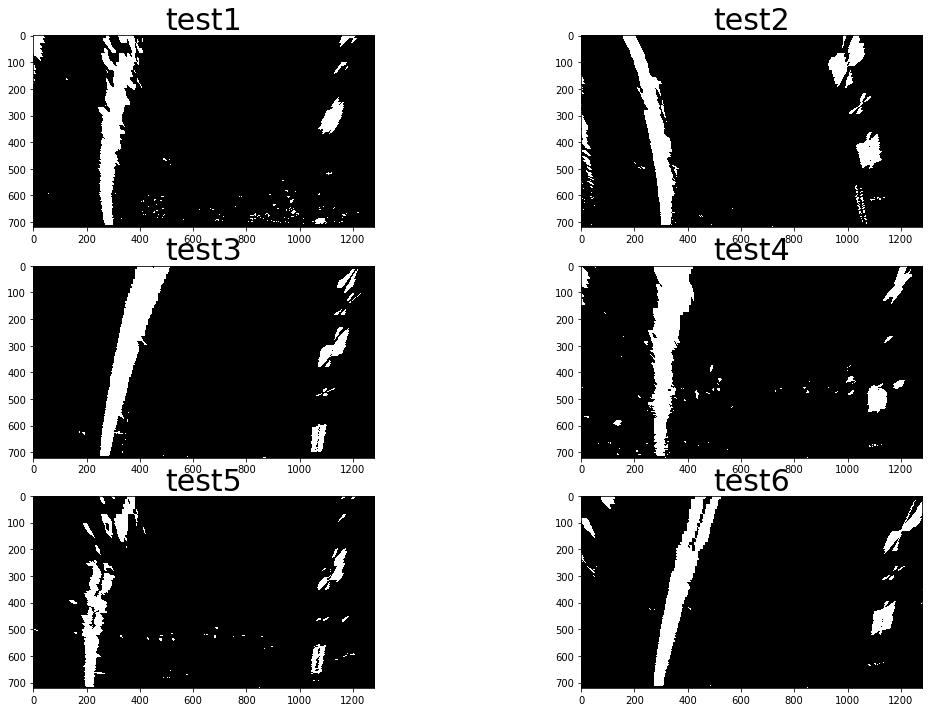

In [213]:
# Test pipelines on all test images
images = glob.glob('test_images/test*.jpg')
fig, axs = plt.subplots(3,2, figsize = (18, 12))
axs = axs.ravel()

for i,fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, Minv = pipeline(img)
    axs[i].imshow(img, cmap = 'gray')
    axs[i].set_title('test{}'.format(i+1), fontsize = 30)
    img_name = fname.split('/')[1]
    plt.imsave(output_dir + 'binary_warp/' + 'binary_warped_' + img_name, img, cmap = 'gray')

### Identify pixels using moving windows

In [214]:
def sliding_window(binary_warped):
    histogram = histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 80

    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        # cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        # cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_lane_inds, right_lane_inds, left_fit, right_fit

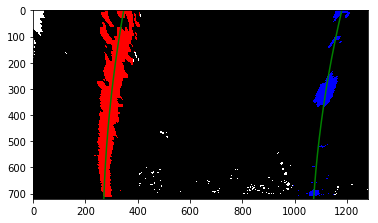

In [215]:
# Still using test1 as example
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary_warped, Minv = pipeline(img)

left_lane_inds, right_lane_inds, left_fit, right_fit = sliding_window(binary_warped)

# Color in left and right line pixels
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.plot(left_fitx, ploty, color='green')
plt.plot(right_fitx, ploty, color='green')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(out_img)
plt.imsave(output_dir + 'polyfit/' + 'polyfit_test1.jpg', out_img)

### Identify pixels using previous frame

In [244]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def polyfit_previous_frame(binary_warped, previous_left_fit, previous_right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (previous_left_fit[0]*(nonzeroy**2) + previous_left_fit[1]*nonzeroy + previous_left_fit[2] - margin)) 
                      & (nonzerox < (previous_left_fit[0]*(nonzeroy**2) + previous_left_fit[1]*nonzeroy + previous_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (previous_right_fit[0]*(nonzeroy**2) + previous_right_fit[1]*nonzeroy + previous_right_fit[2] - margin)) 
                       & (nonzerox < (previous_right_fit[0]*(nonzeroy**2) + previous_right_fit[1]*nonzeroy + previous_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_lane_inds, right_lane_inds, left_fit, right_fit


### Measuring curvature

In [217]:
def measure_curvature (binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/820 # meters per pixel in x dimension
    
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    y_eval = img_size[1] - 1
    
    # Again, extract left and right line pixel positions
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the distance from center
    mid= img_size[0]//2
    left_intercept = left_fit[0] * (y_eval**2) + left_fit[1] * y_eval + left_fit[2]
    right_intercept = right_fit[0] * (y_eval**2) +right_fit[1] * y_eval + right_fit[2]
    distance_from_center = (mid - (left_intercept + right_intercept)//2) * xm_per_pix
    
    return left_curverad, right_curverad, distance_from_center



Radius of curvature for example: Left:  1922.98087738 m, Right:  1648.94784976 m
Distance from lane center for example: -0.13987804878 m


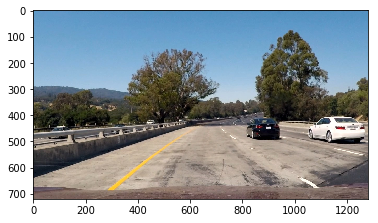

In [218]:
left_rad, right_rad, distance_from_center = measure_curvature(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

plt.imshow(img)
print('Radius of curvature for example:', 'Left: ', left_rad, 'm,', 'Right: ', right_rad, 'm')
print('Distance from lane center for example:', distance_from_center, 'm')

### Drawing the image

In [219]:
def draw_image(img, binary_warped, Minv, left_fit, right_fit, curv_rad, distance_from_center):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    ploty = np.linspace(0, img_size[1] - 1, img_size[1])# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Add curve radius and distance from center on image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of curvature = {:.2f}'.format(curv_rad) + 'm' , (30,60), font, 1.5, (255,255,255), 3, cv2.LINE_AA)
    left_or_right = ''
    if distance_from_center < 0:
        left_or_right = 'right'
    elif distance_from_center > 0:
        left_or_right = 'left'
    else:
        left_or_right = 'middle'
    abs_distance_from_mid = np.abs(distance_from_center)
    if left_or_right == 'middle':
        distance_text = 'In the middle'
    else:
        distance_text = 'Vehicle is {:.2f}'.format(abs_distance_from_mid) + 'm ' + left_or_right + ' of center'
    cv2.putText(result, distance_text, (30,120), font, 1.5, (255,255,255), 3, cv2.LINE_AA)
    return result


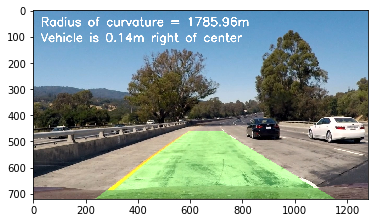

In [221]:
# Test
combined_img = draw_image(img, binary_warped, Minv, left_fit, right_fit, (left_rad + right_rad)/2, distance_from_center)
plt.imshow(combined_img)
plt.imsave(output_dir + 'radius/' + 'radius_center_test1.jpg', combined_img)

In [245]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        # self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        # self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.recent_5_fit = [] 
        #number of fits in self.recent_5_fit
        self.length_of_previous_fit = 0
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    # Set length of recent fit:
    def set_length(self):
        self.length_of_previous_fit = len(self.recent_5_fit)
        
    # Set best fit
    def set_best_fit(self):
        if self.length_of_previous_fit > 0:
            self.best_fit = np.average(self.recent_5_fit, axis = 0)
    
    # Calculate difference b/w coming fit and best_fit
    def get_diffs(self, fit):
        self.diffs = np.abs((fit - self.best_fit)/self.best_fit)
    
    # Append new fit
    def append_fit(self, fit):
        self.recent_5_fit.append(fit)
        self.set_length()
        
    # Update the recent fits if the number of it exceeds 10
    def update_fit(self):
        self.recent_5_fit = self.recent_5_fit[self.length_of_previous_fit - 5:]
        self.set_length()
        
    # Drop the oldest fit of recent fits
    def drop_fit(self):
        self.recent_5_fit = self.recent_5_fit[1:]
        self.set_length()
    
    # Call for add a new fit
    def add_fit(self, fit, inds):
        if fit is None:
            self.detected = False
            if self.recent_5_fit:
                self.drop_fit()
                self.set_best_fit()
        else:
            if self.best_fit is not None:
                self.get_diffs(fit)         
            # Fit is not acceptable
            if not (self.diffs < np.array([0.5, 0.5, 0.1])).all():
                self.detected = False
            
            # If acceptable, append it
            else:
                self.detected = True
                self.append_fit(fit)
                self.set_best_fit()
                # Only consider past 5 accepatable frames' fits
                if self.length_of_previous_fit > 5:
                    self.update_fit()
                    self.set_best_fit()
            

In [252]:
def process_image(img):
    undst = undistort(img)
    #undst = cv2.cvtColor(undst,cv2.COLOR_BGR2RGB)
    binary_img = binary_image(undst)
    binary_warped, _, Minv = warp(binary_img, src, dst)
    img_size = binary_warped.shape[1], binary_warped.shape[0]
    
    if left.detected and right.detected:
        left_lane_inds, right_lane_inds, left_fit, right_fit = polyfit_previous_frame(binary_warped, left.best_fit, right.best_fit)
    else:
        left_lane_inds, right_lane_inds, left_fit, right_fit = sliding_window(binary_warped)
    
    # Make sure the detected lanes are in good position
    if left_fit is not None and right_fit is not None:
        left_intercept = left_fit[0] * (img_size[1]**2) + left_fit[1] * img_size[1] + left_fit[2]
        right_intercept = right_fit[0] * (img_size[1]**2) + right_fit[1] * img_size[1] + right_fit[2]
        
        # The difference of two intercepts should be bewteen 720~920
        diff = right_intercept - left_intercept
        if diff > 920 or diff < 720:
            left_fit = None
            right_fit = None

    left.add_fit(left_fit, left_lane_inds)
    right.add_fit(right_fit, right_lane_inds)
    
    if left_fit is not None and right_fit is not None:
        left_rad, right_rad, distance_from_center = measure_curvature(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
        curv_rad = (left_rad + right_rad)/2.0
        img_out = draw_image(undst, binary_warped, Minv, left_fit, right_fit, curv_rad, distance_from_center)
    #if left.best_fit is not None and right.best_fit is not None:
     #   left_rad, right_rad, distance_from_center = measure_curvature(binary_warped, left.best_fit, right.best_fit, left_lane_inds, right_lane_inds)
      #  curv_rad = (left_rad + right_rad)/2.0
       # img_out = draw_image(undst, binary_warped, Minv, left.best_fit, right.best_fit, curv_rad, distance_from_center)
    else:
        img_out = undst
    
    return img_out

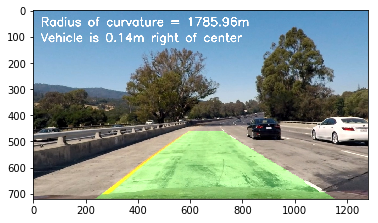

In [253]:
# Test process_image
left = Line()
right = Line()
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
result = process_image(img)

plt.imshow(result)


In [254]:
left = Line()
right = Line()

out_video_name = 'processed_project_video.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(process_image)
%time processed_video.write_videofile(out_video_name, audio=False)

[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


100%|█████████▉| 1260/1261 [05:27<00:00,  3.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video.mp4 

CPU times: user 5min 41s, sys: 1min 9s, total: 6min 50s
Wall time: 5min 28s
